#### 라이브러리

In [1]:
# 한글 폰트 설치

!sudo apt-get install -y fonts-nanum* | tail -n 1
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib

# 필요 라이브러리 설치

!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1



debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 4.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 39 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no suc

In [1]:
# 라이브러리 임포트

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# 폰트 관련 용도
import matplotlib.font_manager as fm

# Colab, Linux
# 나눔 고딕 폰트의 경로 명시
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()

# Window
# font_name = "NanumBarunGothic"

# Mac
# font_name = "AppleGothic"

In [2]:
# 파이토치 관련 라이브러리
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchviz import make_dot
from torchinfo import summary
from tqdm.notebook import tqdm

import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [3]:
# 기본 폰트 설정
# 윈도우에서는 "malgun.ttf" 혹은 "NanumBarunGothic.ttf" 등을 사용할 수 있다. 맥에서는 "AppleGothic.ttf"
plt.rcParams['font.family'] = font_name

# 기본 폰트 사이즈 변경
plt.rcParams['font.size'] = 14

# 기본 그래프 사이즈 변경
plt.rcParams['figure.figsize'] = (6,6)

# 기본 그리드 표시
# 필요에 따라 설정할 때는, plt.grid()
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = ':'


# 마이너스 기호 정상 출력
plt.rcParams['axes.unicode_minus'] = False

# 넘파이 부동소수점 자릿수 표시
np.set_printoptions(suppress=True, precision=4)

#### MNIST 손글씨 숫자 데이터셋

28 * 28 픽셀의 이미지를 이용해 숫자 판별
각 이미지는 [1,28,28]의 텐서 형식으로 이루어짐. 1은 이미지의 색

입력차원은 28 * 28 인 784개의 요소를 1차원 배열로 가공한 데이터가 된다.

output은 총 10가지의 클래스가 존재함.

#### 은닉층 / ReLU
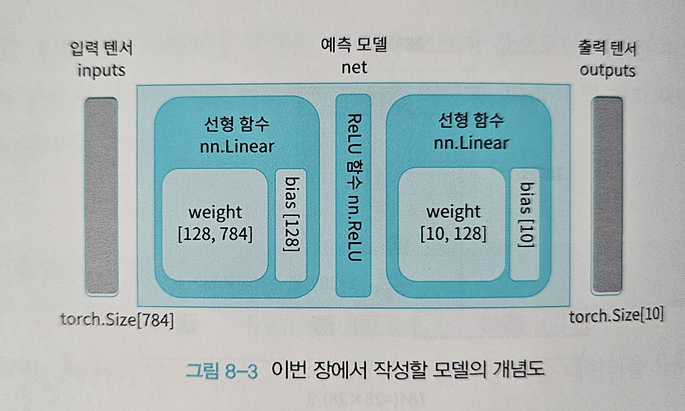
이번 모델부터 은닉층을 포함하게 된다.
다시 말해 2개 층 이상의 선형 함수로 이뤄진 모델을 사용하게 된다.

층을 깊게 만들면 범용성이 높아지고 높은 정확도의 모델이 만들어지게됨.
그리고 이 깊이를 유효하게 하기 위해 선형 함수들 사이에 활성화 함수를 사용함

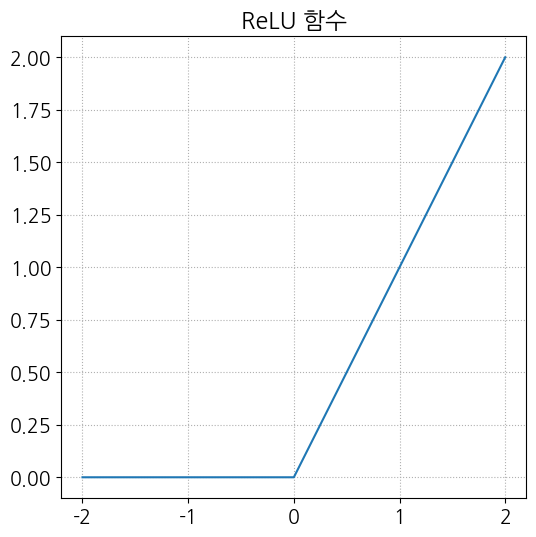

In [4]:
relu = nn.ReLU()
x_np = np.arange(-2, 2.1, 0.25)
x = torch.tensor(x_np).float()
y = relu(x)

plt.plot(x.data, y.data)
plt.title('ReLU 함수')
plt.show()

#### gpu 사용 규칙

1. 텐서 변수는 데이터가 cpu와 gpu중 어디에 속해있는지를 속성으로 갖는다
2. cpu와 gpu사이의 데이터는 to함수로 전송한다.
3. 두 개의 변수가 모두 gpu에 올라와 있으면 gpu로 연산한다.
4. 두 변수중 한 쪽이 cpu, 한 쪽이 gpu면 에러 발생.

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


#### 데이터 전처리
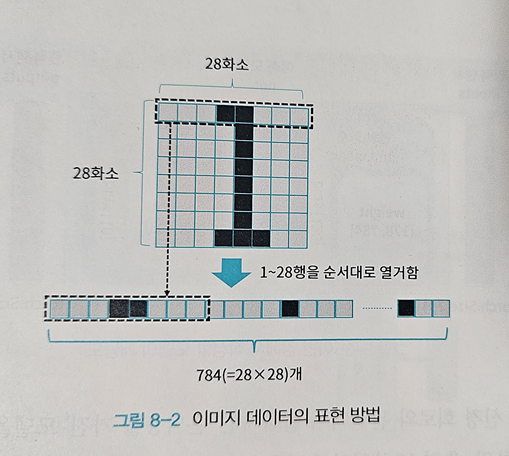
해당 모델에서는 [1,28,28]의 데이터를 784개의 요소를 1차원 배열로 바꿔줘야함.
전처리에서 transform을 이용함.

#### 미니 배치 학습법

배치 학습법: 원래 학습 데이터 전체 건수로 한 번에 경사를 계산
미니 배치 학습법: 학습 데이터를 배치 수마다 가중치 업데이트
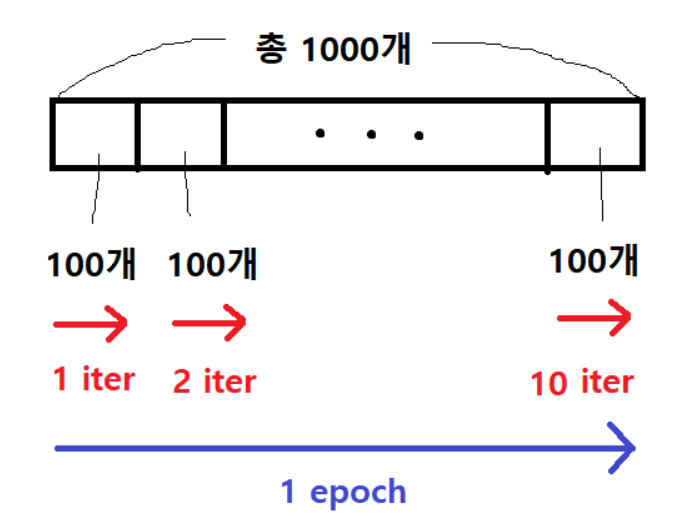

#### 데이터 준비

In [6]:
# 라이브러리 임포트
import torchvision.datasets as datasets

# 다운로드받을 디렉터리명
data_root = './data'

train_set0 = datasets.MNIST(
    # 원본 데이터를 다운로드받을 디렉터리 지정
    root = data_root,
    # 훈련 데이터인지 또는 검증 데이터인지
    train = True,
    # 원본 데이터가 없는 경우, 다운로드를 실행하는지 여부
    download = True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.1MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 456kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.63MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.17MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



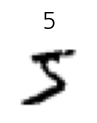

In [8]:
image, label = train_set0[0]

plt.figure(figsize=(1,1))
plt.title(f'{label}')
plt.imshow(image, cmap='gray_r')
plt.axis('off')
plt.show()

In [9]:
import torchvision.transforms as transforms

transform1 = transforms.Compose([
    # 데이터를 텐서로 변환
    transforms.ToTensor(),
])

train_set1 = datasets.MNIST(
    root=data_root,
    train=True,
    download=True,
    transform = transform1)

In [10]:
image, label = train_set1[0]
print('입력 데이터 타입 : ', type(image)) # <class 'torch.Tensor'>
print('입력 데이터 shape : ', image.shape)
print('최솟값 : ', image.data.min())
print('최댓값 : ', image.data.max())

입력 데이터 타입 :  <class 'torch.Tensor'>
입력 데이터 shape :  torch.Size([1, 28, 28])
최솟값 :  tensor(0.)
최댓값 :  tensor(1.)


In [11]:
## Normalize 사용해보기

## 순서 중요
transform2 = transforms.Compose([
    # 데이터를 텐서로 변환
    transforms.ToTensor(),

    # 데이터 정규화
    transforms.Normalize(mean = 0.5,  std = 0.5), # z-transform [-1,1]값으로 변형됨
])

train_set2 = datasets.MNIST(
    root = data_root,
    train = True,
    download = True,
    transform = transform2)

# 변환 결과 확인

image, label = train_set2[0]
print('shape : ', image.shape)
print('최솟값 : ', image.data.min())
print('최댓값 : ', image.data.max())

shape :  torch.Size([1, 28, 28])
최솟값 :  tensor(-1.)
최댓값 :  tensor(1.)


In [12]:
## Lambda를 이용한 1차원 텐서로 변환

transform3 = transforms.Compose([
    # 데이터를 텐서로 변환
    transforms.ToTensor(),

    # 데이터 정규화
    transforms.Normalize(0.5, 0.5),

    # 현재 텐서를 1계 텐서로 변환
    transforms.Lambda(lambda x: x.view(-1)),
])

train_set3 = datasets.MNIST(
    root = data_root,
    train = True,
    download=True,
    transform = transform3)

# 변환 결과 확인

image, label = train_set3[0]
print('shape : ', image.shape)
print('최솟값 : ', image.data.min())
print('최댓값 : ', image.data.max())

shape :  torch.Size([784])
최솟값 :  tensor(-1.)
최댓값 :  tensor(1.)


In [13]:
## 최종 데이터 전처리

transform = transforms.Compose([
    # (1) 데이터를 텐서로 변환
    transforms.ToTensor(),

    # (2) 데이터 정규화
    transforms.Normalize(0.5, 0.5),

    # (3) 1계 텐서로 변환
    transforms.Lambda(lambda x: x.view(-1)),
])

# 훈련용 데이터셋 정의
train_set = datasets.MNIST(
    root = data_root,
    train = True,
    download = True,
    transform = transform)

# 검증용 데이터셋 정의
test_set = datasets.MNIST(
    root = data_root,
    train = False,
    download = True,
    transform = transform)

#### 데이터 로더를 통한 미니 배치 데이터 생성

In [14]:
from torch.utils.data import DataLoader

batch_size = 500

train_loader = DataLoader(
    dataset = train_set,
    batch_size = batch_size,
    shuffle = True)

test_loader = DataLoader(
    dataset = test_set,
    batch_size = batch_size,
    shuffle = False)

# 훈련 데이터에만 셔플을 적용함

In [15]:
## 데이터 로더 확인

# 몇 개의 그룹으로 데이터를 가져올 수 있는가
print(len(train_loader))      # 60,000/500

# 데이터로더로부터 가장 처음 한 세트를 가져옴
for images, labels in train_loader:
    break

print(images.shape)
print(labels.shape)

120
torch.Size([500, 784])
torch.Size([500])


#### 모델 정의

In [17]:
n_input = image.shape[0]
n_output = len(set(list(labels.data.numpy())))
n_hidden = 128
print(f'n_input:{n_input}  n_hidden:{n_hidden} n_output:{n_output}')

n_input:784  n_hidden:128 n_output:10


In [18]:
class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_hidden)
        self.l2 = nn.Linear(n_hidden, n_output)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        return x3

In [20]:
# 난수 고정
torch.manual_seed(123)
torch.cuda.manual_seed(123)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

# 모델 인스턴스 생성
net = Net(n_input, n_output, n_hidden).to(device)

In [21]:
## hyperparameters

lr = 0.01
optimizer = optim.SGD(net.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

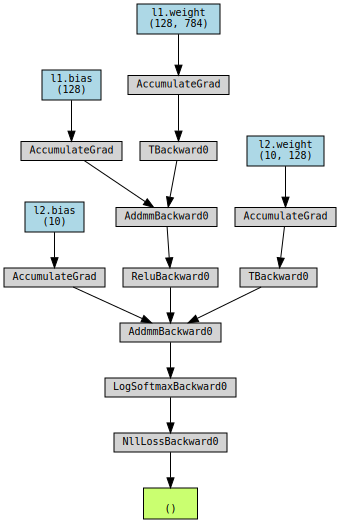

In [23]:
## visualize
for images, labels in train_loader:
    break

inputs = images.to(device)
labels = labels.to(device)

# 예측 계산
outputs = net(inputs)

#  손실 계산
loss = criterion(outputs, labels)

# 손실 계산 그래프 시각화
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

#### 실제 모델 수행

In [24]:
# 난수 고정
torch.manual_seed(123)
torch.cuda.manual_seed(123)


# 학습률
lr = 0.01

# 모델 초기화
net = Net(n_input, n_output, n_hidden).to(device)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 최적화 함수: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

# 반복 횟수
# num_epochs = 100
num_epochs = 10


# 평가 결과 기록
history = np.zeros((0,5))

In [25]:
# tqdm 라이브러리 임포트
from tqdm.notebook import tqdm

# 반복 계산 메인 루프
for epoch in range(num_epochs):
    train_acc, train_loss = 0, 0
    val_acc, val_loss = 0, 0
    n_train, n_test = 0, 0

    # 훈련 페이즈
    for inputs, labels in tqdm(train_loader):
        n_train += len(labels)

        # GPU로 전송
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 경사 초기화
        optimizer.zero_grad()

        # 예측 계산
        outputs = net(inputs)

        # 손실 계산
        loss = criterion(outputs, labels)

        # 경사 계산
        loss.backward()

        # 파라미터 수정
        optimizer.step()

        # 예측 라벨 산출
        predicted = torch.max(outputs, 1)[1]

        # 손실과 정확도 계산
        train_loss += loss.item()
        train_acc += (predicted == labels).sum().item()

    # 예측 페이즈
    for inputs_test, labels_test in test_loader:
        n_test += len(labels_test)

        inputs_test = inputs_test.to(device)
        labels_test = labels_test.to(device)


        # 예측 계산
        outputs_test = net(inputs_test)

        # 손실 계산
        loss_test = criterion(outputs_test, labels_test)

        # 예측 라벨 산출
        predicted_test = torch.max(outputs_test, 1)[1]

        # 손실과 정확도 계산
        val_loss +=  loss_test.item()
        val_acc +=  (predicted_test == labels_test).sum().item()

    # 평가 결과 산출, 기록
    train_acc = train_acc / n_train
    val_acc = val_acc / n_test
    train_loss = train_loss * batch_size / n_train
    val_loss = val_loss * batch_size / n_test
    print (f'Epoch [{epoch+1}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
    item = np.array([epoch+1 , train_loss, train_acc, val_loss, val_acc])
    history = np.vstack((history, item))

  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [1/10], loss: 1.82932 acc: 0.56960 val_loss: 1.32629, val_acc: 0.74660


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [2/10], loss: 1.03889 acc: 0.79537 val_loss: 0.79661, val_acc: 0.83180


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [3/10], loss: 0.70809 acc: 0.84110 val_loss: 0.60256, val_acc: 0.85850


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [4/10], loss: 0.57300 acc: 0.86057 val_loss: 0.51192, val_acc: 0.87140


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [5/10], loss: 0.50223 acc: 0.87102 val_loss: 0.45827, val_acc: 0.87930


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [6/10], loss: 0.45883 acc: 0.87877 val_loss: 0.42422, val_acc: 0.88650


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [7/10], loss: 0.42938 acc: 0.88327 val_loss: 0.40076, val_acc: 0.88970


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [8/10], loss: 0.40813 acc: 0.88743 val_loss: 0.38285, val_acc: 0.89370


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [9/10], loss: 0.39176 acc: 0.89065 val_loss: 0.36857, val_acc: 0.89680


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [10/10], loss: 0.37875 acc: 0.89313 val_loss: 0.35741, val_acc: 0.89930


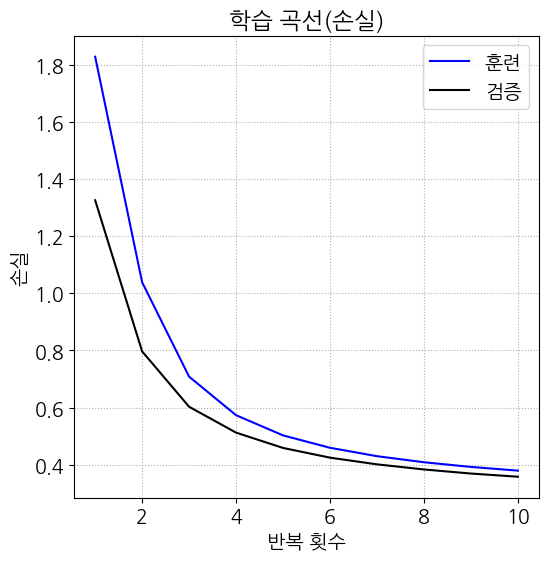

In [26]:
# 학습 곡선 출력(손실)

plt.plot(history[:,0], history[:,1], 'b', label='훈련')
plt.plot(history[:,0], history[:,3], 'k', label='검증')
plt.xlabel('반복 횟수')
plt.ylabel('손실')
plt.title('학습 곡선(손실)')
plt.legend()
plt.show()

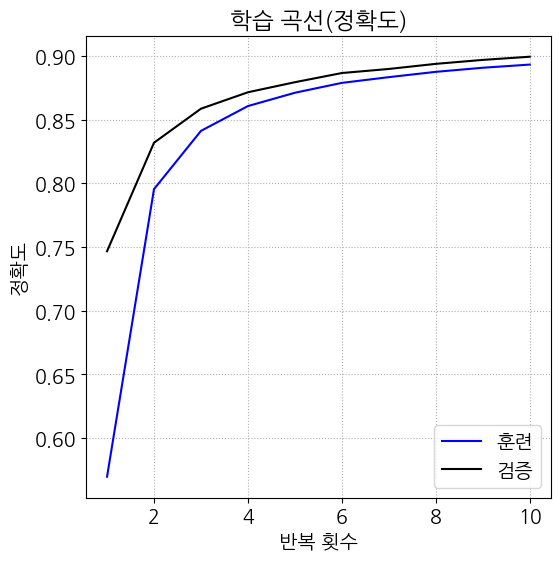

In [27]:
# 학습 곡선 출력(정확도)

plt.plot(history[:,0], history[:,2], 'b', label='훈련')
plt.plot(history[:,0], history[:,4], 'k', label='검증')
plt.xlabel('반복 횟수')
plt.ylabel('정확도')
plt.title('학습 곡선(정확도)')
plt.legend()
plt.show()

In [ ]:
# 모델 정의
# 784입력 10출력을 갖는 2개의 은닉층을 포함한 신경망

class Net2(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()

        # 첫번째 은닉층 정의(은닉층 노드 수: n_hidden)
        self.l1 = nn.Linear(n_input, n_hidden)

        # 두번째 은닉층 정의(은닉층 노드 수: n_hidden)
        self.l2 = nn.Linear(n_hidden, n_hidden)

        # 출력층 정의
        self.l3 = nn.Linear(n_hidden, n_output)

        # ReLU 함수 정의
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        x4 = self.relu(x3)
        x5 = self.l3(x4)
        return x5

위 : 은닉층 1개 사용
아래 : 은닉층 두 개 사용

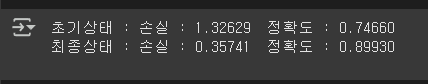

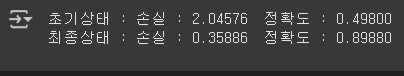